In [1]:
###----Linear Discriminant Analysis----###
#Load các thư viện cần dùng
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import eigh
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
#Load dữ liệu
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
#Rename lại tên các cột dữ liệu
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline'] 
#In ra 5 bản ghi đầu tiên
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
#In ra shape của data, chúng ta có 178 bản ghi với 13 features với 1 cột label
df_wine.shape

(178, 14)

In [4]:
#In ra số lượng từng class
df_wine['Class label'].value_counts()

2    71
1    59
3    48
Name: Class label, dtype: int64

In [5]:
#Phân chia dữ liệu bằng train_test_split
#Phân tách dữ liệu X là tất cả 13 cột features và y là cột class label
X_train, y_train = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values


Step 1: Chuẩn hóa dữ liệu ($\textit{d}$-chiều) ($\textit{d}$ là số feature).

Cách tính của StandardScaler là:
    \begin{equation*}
        x_{scale}=\dfrac{x-\mu}{\sigma}
    \end{equation*}

In [6]:
#Cài đặt StandardScaler
sc = StandardScaler()

#Transform tập train về  dạng standard bằng cách trừ mean chia cho độ lệch chuẩn
X_train_std = sc.fit_transform(X_train)

In [7]:
#Phương sai có hiệu chỉnh 
X_train_std = (X_train - X_train.mean(axis = 0))/X_train.std(axis = 0, ddof = 1)

Step 2: Với mỗi class, tính vectơ trung bình $\textit{d}$ chiều.

Mỗi vector trung bình $m_i$ chứa các giá trị trung bình
theo feature $\mu_m$ tương ứng với samples của class i
\begin{equation*}
m_i=\dfrac{1}{n_i}\displaystyle\sum_{x\in D_i}^{c}x_m
\end{equation*}

In [8]:
#Hàm tính vectơ trung bình d chiều
def calculate_mean_feature(X_train_std,y_train):
    #Khai báo mean_vecs là một list rỗng
    mean_vecs = []
    #Chạy vòng lặp theo số lượng label, ở đây có 3 label.
    for label in range(1, 4):
        #Nối vào cuối means_vector các vectơ trung bình của từng label theo từng cột
        mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    return mean_vecs 

#Xét chỉ hiện 4 chữ số thập phân sau dấu phẩy
np.set_printoptions(precision=4)
#In ra mean vector cần tính
mean_vecs=calculate_mean_feature(X_train_std,y_train)
for label in range(1,4):
    print('Mean Vector: Label ',label,'\n', np.array([mean_vecs[label - 1]]).T)

Mean Vector: Label  1 
 [[ 0.9166]
 [-0.2915]
 [ 0.3247]
 [-0.7359]
 [ 0.4619]
 [ 0.8709]
 [ 0.9542]
 [-0.5774]
 [ 0.5389]
 [ 0.2028]
 [ 0.4576]
 [ 0.7692]
 [ 1.1712]]
Mean Vector: Label  2 
 [[-0.8892]
 [-0.3613]
 [-0.4437]
 [ 0.2225]
 [-0.3635]
 [-0.0579]
 [ 0.0516]
 [ 0.0145]
 [ 0.0688]
 [-0.8504]
 [ 0.4324]
 [ 0.2446]
 [-0.7221]]
Mean Vector: Label  3 
 [[ 0.1886]
 [ 0.8928]
 [ 0.2572]
 [ 0.5754]
 [-0.03  ]
 [-0.9848]
 [-1.2492]
 [ 0.6882]
 [-0.7641]
 [ 1.0086]
 [-1.202 ]
 [-1.3073]
 [-0.3715]]


Step 3: Xây dựng ma trận phân tán giữa các class $S_B$ (between-class scatter matrix) và ma trận phân tán trong class (within-class scatter matrix) $S_w$.

Ta sẽ tính ma trận phân tán trong class (Within-class
scatter matrix $S_w$):
    \begin{equation*}
        S_{w}=\displaystyle\sum_{i=1}^{c}S_i
    \end{equation*}
Trong đó $S_i$ chính là ma trận phân tán của class i,
được tính như sau:
    \begin{equation*}
        S_i=\displaystyle\sum_{x\in D_i}^{c}(x-m_i)(x-m_i)^{T}
    \end{equation*}

Khi chúng ta chia ma trận phân tán bởi số sample trong class, ta thấy rằng tính ma trận phân tán
thực ra là giống như tính ma trận hiệp phương sai (covariance matrix $\Sigma$):
                                                   \begin{equation*}
                                                       \Sigma=\dfrac{1}{n_i}S_W=\dfrac{1}{n_i}\sum_{x\in D_i}^{c}(x-m_i)(x-m_i)^{T}
                                                   \end{equation*}

In [9]:
#Hàm tính ma trận phân tán trong class
def build_SW(X_train_std,y_train,mean_vecs):
    #Đặt số chiều là số features
    d=13
    #Khai báo ma trận không, kích thước d x d
    S_W = np.zeros((d, d))
    for label, mv in zip(range(1, 4), mean_vecs):
        class_scatter = np.cov(X_train_std[y_train == label].T)
        S_W += class_scatter
    return S_W
S_W=build_SW(X_train_std,y_train,mean_vecs)
S_W.shape

(13, 13)

Ta sẽ tính ma trận phân tán giữa các class $S_B$ như sau:\
Với $m$ là mean tổng của tất cả sample của tất cả class
    \begin{equation*}
        S_B=\displaystyle\sum_{i=1}^{c}n_i(m_i-m)(m_i-m)^{T}
    \end{equation*}

In [10]:
#Hàm tính ma trận phân tán giữa các class
def build_SB(X_train_std,y_train,mean_vecs):
    #Tính vectơ trung bình của tất cả sample
    mean_overall = np.mean(X_train_std, axis=0)
    #Khai báo số chiều bằng số features
    d = 13
    #Khai báo ma trận không, kích cỡ d x d
    S_B = np.zeros((d, d))
    for i, mean_vec in enumerate(mean_vecs):
        n = X_train[y_train == i + 1, :].shape[0]
        mean_vec = mean_vec.reshape(d, 1)  
        mean_overall = mean_overall.reshape(d, 1)
        S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
    return S_B

S_B=build_SB(X_train_std,y_train,mean_vecs)
S_B.shape

(13, 13)

Step 4: Tính vectơ riêng và trị riêng tương ứng của ma trận $S_w^{-1}S_B$.

In [11]:
#Hàm tính vectơ riêng, trị riêng của ma trận cần tìm
def calculate_eigen(S_B,S_W):
    return np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_values,eigen_vector=calculate_eigen(S_B,S_W)
print('The shape of eigen values: ',eigen_values.shape)
print('The shape of eigen vector: ',eigen_vector.shape)

The shape of eigen values:  (13,)
The shape of eigen vector:  (13, 13)


Step 5: Sắp xết các trị riêng giảm dần.

In [12]:
#Chuyển đổi từ dạng tuple sang list để thuận tiện
eigen_pairs = [(np.abs(eigen_values[i]), eigen_vector[:, i])
               for i in range(len(eigen_values))]

#Sắp xếp các trị riêng giảm dần
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

#In ra kết quả theo chiều giảm dần các trị riêng
for eigen_values in eigen_pairs:
    print(eigen_values[0])

546.4164942544581
243.23261924246484
9.340226749345777e-14
3.728807674126057e-14
3.5141673953922935e-14
3.100522364061576e-14
3.100522364061576e-14
1.535015713091948e-14
9.485170926622045e-15
8.848285748656519e-15
8.848285748656519e-15
1.9979137577554484e-15
0.0


Step 6: Chọn $\textit{k}$ vectơ riêng tương ứng với $\textit{k}$ trị riêng lớn nhất để xây dựng một ma trận chuyển đổi $W$ có $dxk$ chiều.

In [13]:
#Ta có thể nhận thấy là có 2 trị riêng lớn hẳn hơn 0
#Các trị riêng còn lại đều rất nhỏ.

#Lấy các trị riêng ra
eigenvalues = [eigenvalues for (eigenvalues, eigenvector) in eigen_pairs]

#Đưa về dạng numpy array
eigenvalúess = np.array(eigenvalues)

#tính tổng tích luỹ các trị riêng
cumsum = np.cumsum(eigenvalues)
cumsum /= cumsum[-1]
cumsum[0]
#Ta có thể thấy 2 trị riêng lớn nhất đã capture gần như
#100% thông tin, nên ta sẽ lấy 2 trị riêng này 

0.6919737955947028

In [14]:
#Xếp 2 trị riêng đã chọn thành các cột để tạo ra ma trận
#chuyển đổi W
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)
print('The shape of transformation matrix: ',w.shape)

Matrix W:
 [[ 0.1301 -0.4225]
 [-0.0725 -0.1823]
 [ 0.0411 -0.3905]
 [-0.21    0.2966]
 [ 0.011  -0.0077]
 [-0.1606  0.0109]
 [ 0.7338  0.2778]
 [ 0.0764  0.1153]
 [-0.0236  0.1237]
 [-0.3032 -0.2793]
 [ 0.0904  0.2465]
 [ 0.3717  0.0164]
 [ 0.3508 -0.5503]]
The shape of transformation matrix:  (13, 2)


Step 7: Chiếu mẫu lên không gian con mới sử dụng ma trận chuyển đổi $W$.

Chúng ta sẽ chuyển đổi tập train bằng cách nhân với ma trận chuyển đổi
\begin{equation*}
X'=XW
\end{equation*}

In [15]:
X_train_lda = X_train_std.dot(w)
X_train_lda.shape
#Lúc này tập train chỉ còn 2 chiều.

(178, 2)

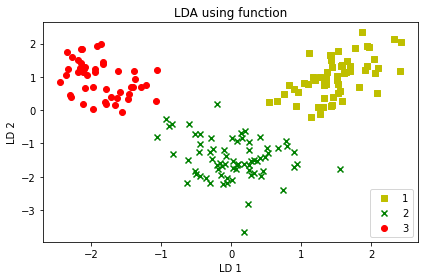

In [16]:
#Chúng ta sẽ minh hoạ tập train sau khi đã thực hiện
#LDA lên để xem các class đã phân tách nhau như thế nào

#Xét tông màu và markers
colors = ['y', 'g', 'r']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.title('LDA using function')
plt.tight_layout()
#Chúng ta có thể thấy các tập đều tách rời nhau

So sánh với thuật toán LDA trong thư viện Scikit-Learn

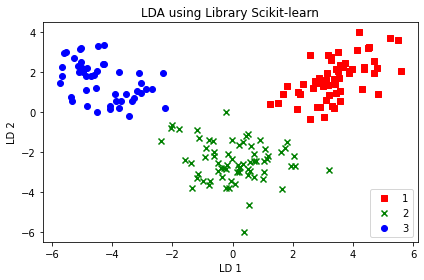

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda_sklearn = lda.fit_transform(X_train_std, y_train)

colors = ['r', 'g', 'b']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda_sklearn[y_train == l, 0],
                X_train_lda_sklearn[y_train == l, 1],
                c=c, label=l, marker=m)
plt.title('LDA using Library Scikit-learn')
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()

In [18]:
dir(X_train_lda_sklearn)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__